## Generative model for a Human Pancreas Topograhic Maps

Data from Tosti et al, 2021

In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [21]:
from sonar import sonar, utils, generator

In [22]:
rel_kernel_path = 'test/ISS-pancreas' #"."


In [23]:
# Define the cluster labels of the pancreas tissue matrix:

cluster_labels = ['background',
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
 'B cell',
 'T cell',
# 'Endothelial'
]

In [24]:
n_sample = 2

# Load the pancreas tissue matrix:

tissue_matrix = np.load(os.path.join( *rel_kernel_path.split('/'), 'data','sample_matrices.npz'))['sample_'+str(n_sample)]

In [25]:
# plt.figure(figsize=(10,10))
# plt.imshow(tissue_matrix.argmax(axis=0),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)!=0).astype(float))

# # Create a legend for different tissue types:
# legend_elements = [plt.scatter([],[],c=plt.cm.nipy_spectral(i/len(cluster_labels)),label=cluster_labels[i]) for i in range(len(cluster_labels))]

# plt.legend(handles=legend_elements,loc='upper right')

In [26]:
tissue_matrix.shape

(16, 6514, 11948)

In [27]:
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()[:,1000:2000,1000:2000,]

del tissue_matrix

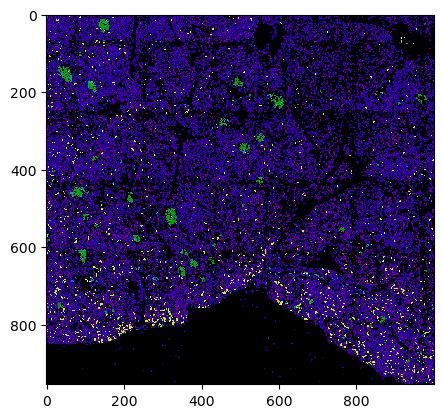

In [28]:
plt.imshow(rescaled.argmax(axis=0),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(rescaled.sum(0)!=0).astype(float))

Changing tasks between cpu and gpu

In [29]:
import torch

# if torch.cuda.is_available():
#     import torch as t
#     device = 'cuda:0' # put it in a gpu
# else:
import torch as t
device='cuda'



In [30]:
def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 150
lin = 10

son = sonar.Sonar(max_radius=rad_,linear_steps=lin,device=device)

radii,cooc_template_ = son.co_occurrence_from_tensor(rescaled,interpolate=False,normalize=False,progbar=True)


  0%|                                                                                                                                                                                                          | 0/136.0 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136.0 [00:00<00:00, 792.02it/s]


### Run generative model:

In [34]:
import shutil
if os.path.exists('./test/ISS-pancreas/output/generator-frames'):
    shutil.rmtree('./test/ISS-pancreas/output/generator-frames')

gen = generator.Generator(sonar=son,shape=rescaled.shape[1:])

sample = gen.generate(template_co_occurrence=cooc_template_.copy(),
                      iterations=1000,
                      momentum=0.5,
                      momentum_map=0.9,
                      lr=0.5,
                      lr_decay=2,
                      init_mode='random_uniform',
                      render_args = {'steps_per_frame':5,'save_dir':'./test/ISS-pancreas/output/generator-frames'})



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:53<00:00,  1.87it/s]


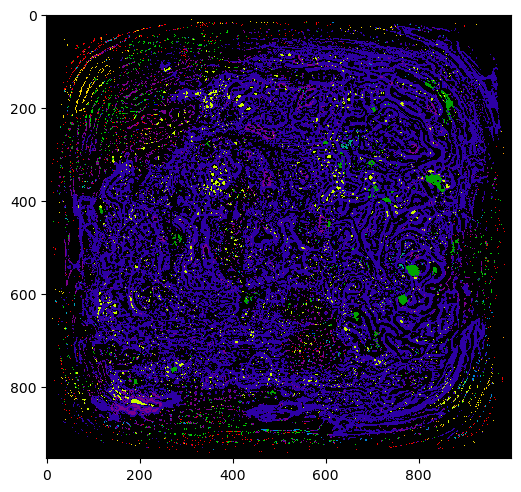

In [35]:
plt.figure(figsize=(6,6))

plt.imshow(sample.argmax(0).cpu(),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1)

In [33]:
sample[:,0,0]

tensor([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.9663e-10, 0.0000e+00,
        2.3412e-22, 7.1760e-15, 1.9118e-03, 2.4131e-18, 0.0000e+00, 1.6000e-06,
        2.1047e-08, 2.2328e-07, 0.0000e+00, 0.0000e+00], device='cuda:0')